In [104]:
from task_2_f import *

In [105]:
train_df = pd.read_csv('data/train.csv')

ecfc = train_df.iloc[:, 200:2248].values
fcfc = train_df.iloc[:, 2248:-1].values
smiles_list = train_df['smiles'].tolist()

labels = train_df[['smiles', 'class']]
descriptors = train_df.iloc[:, :200]


aller dans la matrix

In [106]:
try :
    tanimoto_matrix_ecfc = np.load('data/tanimoto_matrix_ecfc.npy')
    tanimoto_matrix_fcfc = np.load('data/tanimoto_matrix_fcfc.npy')
except:
    # Réduire la dimension des empreintes par modulo
    ecfc_reduced = reduce_fingerprints_by_modulo(ecfc, target_dim=256, binarize=True)
    fcfc_reduced = reduce_fingerprints_by_modulo(fcfc, target_dim=256, binarize=True)
    print(ecfc_reduced.shape, fcfc_reduced.shape)
    #Convertir les empreintes en vecteurs de bits
    ecfc_bitvect = [numpy_to_bitvect(fp) for fp in tqdm(ecfc_reduced)]
    fcfc_bitvect = [numpy_to_bitvect(fp) for fp in tqdm(fcfc_reduced)]
    # Calculer la matrice de Tanimoto
    tanimoto_matrix_ecfc = calculate_tanimoto_matrix(ecfc_bitvect)
    tanimoto_matrix_fcfc = calculate_tanimoto_matrix(fcfc_bitvect)
    # Sauvegarder les matrices de Tanimoto
    np.save('data/tanimoto_matrix_ecfc.npy', tanimoto_matrix_ecfc)
    np.save('data/tanimoto_matrix_fcfc.npy', tanimoto_matrix_fcfc)

In [107]:
dist_matrix = calculate_distance_matrix(tanimoto_matrix_ecfc, tanimoto_matrix_fcfc) # i am the chosen one

rassembler les troupes

In [108]:
# clusters = cluster_hierarchical(dist_matrix, target_cluster_size=60)

In [109]:
clusters = cluster_hierarchical_min_size(dist_matrix, target_cluster_size=80, min_size=20)

🔸 Fusion de 28 petits clusters (<20)...


In [110]:
print("Nombre de clusters hiérarchiques:", len(set(clusters)))

print("Taille des plus grands clusters:")
cluster_sizes = np.bincount(clusters)
sorted_cluster_sizes = sorted(cluster_sizes, key=lambda x: x, reverse=True)
for i, size in enumerate(sorted_cluster_sizes[:20]):
    print(f"Cluster {i+1}: {size} molécules")
print("Taille moyenne des clusters:", np.mean(cluster_sizes))
print("Deviation standard des tailles de clusters:", np.std(cluster_sizes))

Nombre de clusters hiérarchiques: 89
Taille des plus grands clusters:
Cluster 1: 430 molécules
Cluster 2: 404 molécules
Cluster 3: 373 molécules
Cluster 4: 368 molécules
Cluster 5: 283 molécules
Cluster 6: 271 molécules
Cluster 7: 270 molécules
Cluster 8: 238 molécules
Cluster 9: 221 molécules
Cluster 10: 216 molécules
Cluster 11: 213 molécules
Cluster 12: 210 molécules
Cluster 13: 195 molécules
Cluster 14: 169 molécules
Cluster 15: 168 molécules
Cluster 16: 158 molécules
Cluster 17: 158 molécules
Cluster 18: 144 molécules
Cluster 19: 137 molécules
Cluster 20: 130 molécules
Taille moyenne des clusters: 80.47008547008546
Deviation standard des tailles de clusters: 87.66218889310919


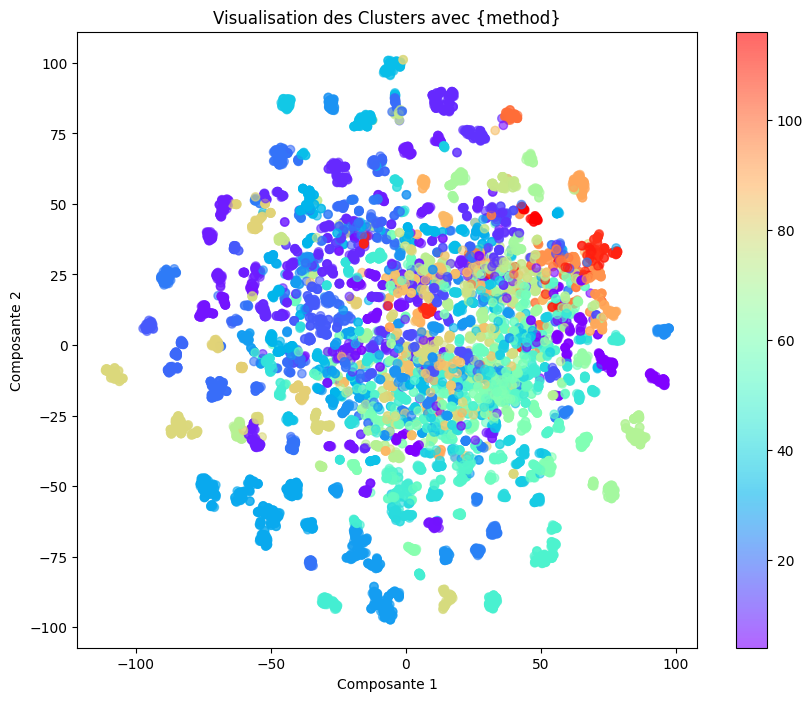

In [ ]:
# visualize_clusters(dist_matrix, clusters, 't-sne')

entraînement

In [112]:
split = split_by_series(smiles_list, labels, clusters, test_size=0.2)

smiles_train = split['smiles_train']
smiles_test = split['smiles_test']
y_train = split['y_train']
y_test = split['y_test']
print("Train/Val split sizes:", len(smiles_train), len(smiles_test))


data = descriptors.merge(pd.DataFrame({'smiles': smiles_list, 'cluster': clusters}), on='smiles', how='right').merge(labels, on='smiles', how='right')


# Split the data into training and test sets based on the clusters
train_df = data.merge(
    pd.DataFrame({'smiles': smiles_train}),
    on='smiles', how='right'
)
test_df = data.merge(
    pd.DataFrame({'smiles': smiles_test}),
    on='smiles', how='right'
)
print(train_df.shape, test_df.shape)
# print(train_df.head())

X_train = train_df.iloc[:, 1:-2].values
X_test = test_df.iloc[:, 1:-2].values
y_train = train_df['class'].values
y_test = test_df['class'].values

print(X_train.shape, X_test.shape)

Train/Val split sizes: 7516 1899
(7516, 202) (1899, 202)
(7516, 199) (1899, 199)


In [113]:
# Drop clusters with no class 1 (abandoned functoinality)
cluster_df = train_df.groupby('cluster')['class'].agg(['sum', 'count'])
valid_clusters = cluster_df.query('sum > 0 and sum < count').index
df_filtered = train_df[train_df['cluster'].isin(valid_clusters)]

X_train_filtered = X_train[df_filtered.index]
y_train_filtered = y_train[df_filtered.index]
cluster_train_labels_filtered = df_filtered['cluster'].values

print("Filtered train set size:", len(X_train_filtered), len(y_train_filtered))


Filtered train set size: 7471 7471


In [137]:
# NEW PLAN 
from sklearn.model_selection import train_test_split

data = descriptors.merge(pd.DataFrame({'smiles': smiles_list, 'cluster': clusters}), on='smiles', how='right')

X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], labels['class'],
                                                    test_size=0.2, 
                                                    stratify=labels['class'], 
                                                    random_state=12)

print(X_train.shape, X_test.shape)

(7532, 200) (1883, 200)


téléchargement des armes

In [115]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score


# XG BOOOOOST

In [116]:
# # === Étape 1 : Prétraitement ===
# # Normalisation des features continues
# # scaler = StandardScaler()
# # X_train_scaled = scaler.fit_transform(X_train)
# # X_test_scaled = scaler.transform(X_test)

# # # Optionnel : suppression des features quasi-constantes
# # selector = VarianceThreshold(threshold=0.01)
# # X_train_sel = selector.fit_transform(X_train_scaled)
# # X_test_sel = selector.transform(X_test_scaled)

# # X_train = X_train_sel
# # X_test = X_test_sel

# # Groupes pour GroupKFold (séries chimiques)
# cluster_train_labels = [clusters[smiles_list.index(s)] for s in smiles_train]

# # === Étape 2 : Modèle XGBoost + GridSearch ===
# xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# param_grid = {
#     'n_estimators': [100, 300],
#     'max_depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# cv = GroupKFold(n_splits=5)
# grid = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=cv.split(X_train, y_train, groups=cluster_train_labels),
#     verbose=1,
#     n_jobs=-1
# )

# # === Étape 3 : Entraînement ===
# grid.fit(X_train, y_train)
# best_model = grid.best_estimator_
# print("✅ Best parameters:", grid.best_params_)


In [117]:
# # === Étape 4 : Évaluation sur test set (clusters exclus) ===
# y_pred = best_model.predict(X_test)

# print("\n\nClassification Report:")
# print("========================================")
# print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=4))


# kappa_score = cohen_kappa_score(y_pred, y_test)
# print(f"Cohen's Kappa Score: {kappa_score}")
# print("Accuracy:", accuracy_score(y_test, y_pred))


# # Calculer et afficher la matrice de confusion
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap=plt.cm.Blues)
# plt.title('Matrice de Confusion')
# plt.show()


# LA FORET

In [118]:
# cluster_train_labels = [clusters[smiles_list.index(s)] for s in smiles_train]

from sklearn.model_selection import StratifiedKFold


rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# param_grid = {
#     'n_estimators': [100, 300],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'max_features': ['sqrt', 'log2']
# }

param_grid = {'max_depth': [20],
              'max_features': ['sqrt'],
              'min_samples_leaf': [1],
              'min_samples_split': [5],
              'n_estimators': [300]
              }

cluster_train_labels = X_train['cluster'].values


cv = GroupKFold(n_splits=5).split(X_train.drop(columns=['cluster']), y_train, groups=cluster_train_labels)
# cv = list(cv)  # Convertir en liste pour éviter de le recalculer plusieurs fois

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# === Étape 3 : Entraînement ===
grid.fit(X_train.drop(columns=['cluster']), y_train)
best_model = grid.best_estimator_
print("✅ Best parameters:", grid.best_params_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
✅ Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}




Classification Report:
              precision    recall  f1-score   support

     Class 0     0.7834    0.8217    0.8021       920
     Class 1     0.8214    0.7830    0.8017       963

    accuracy                         0.8019      1883
   macro avg     0.8024    0.8024    0.8019      1883
weighted avg     0.8028    0.8019    0.8019      1883

Cohen's Kappa Score: 0.6040493726939349
Accuracy: 0.8019118428040362


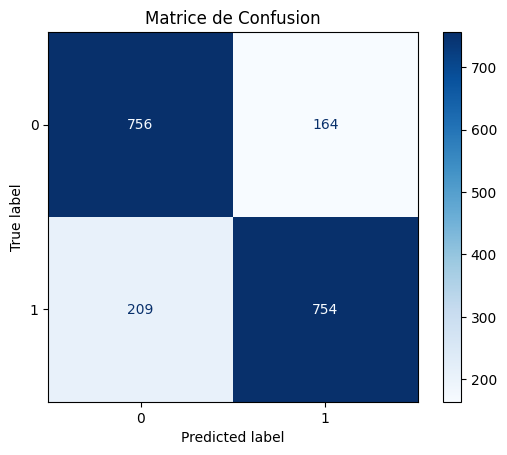

In [119]:
# === Étape 4 : Évaluation sur test set (clusters exclus) ===
y_pred = best_model.predict(X_test.drop(columns=['cluster']))

print("\n\nClassification Report:")
print("========================================")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=4))


kappa_score = cohen_kappa_score(y_pred, y_test)
print(f"Cohen's Kappa Score: {kappa_score}")
print("Accuracy:", accuracy_score(y_test, y_pred))


# Calculer et afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()

# Cohen's Kappa Score: 0.623844585947005
# Accuracy: 0.8120021242697822

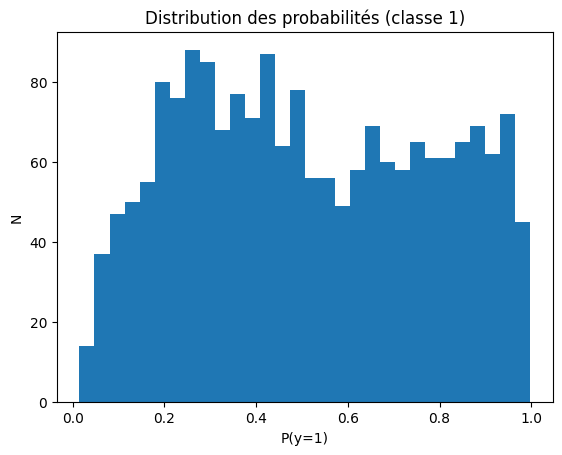

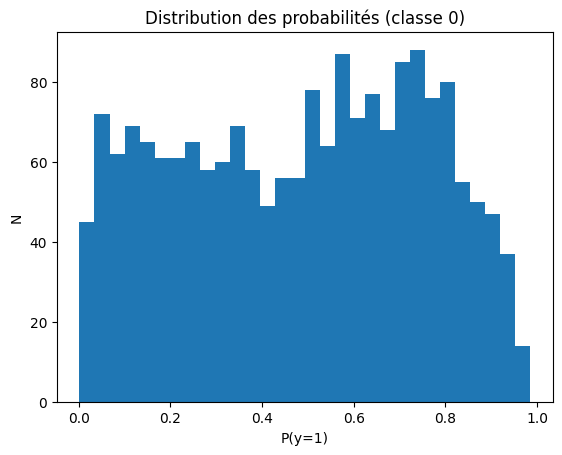

In [120]:
y_proba = best_model.predict_proba(X_test.drop(columns=['cluster']))

# Analyse des probabilités
plt.hist(y_proba[:, 1], bins=30)
plt.title("Distribution des probabilités (classe 1)")
plt.xlabel("P(y=1)"); plt.ylabel("N")
plt.show()


# Analyse des probabilités
plt.hist(y_proba[:, 0], bins=30)
plt.title("Distribution des probabilités (classe 0)")
plt.xlabel("P(y=1)"); plt.ylabel("N")
plt.show()




In [121]:
from sklearn.metrics import accuracy_score
import pandas as pd

# Associer les prédictions et labels aux clusters
test_df_eval = X_test.copy()
test_df_eval['y_true'] = y_test
test_df_eval['y_pred'] = y_pred
test_df_eval['cluster'] = X_test['cluster'].values  # s'assurer que 'cluster' est bien là

# Accuracy par cluster
per_series_scores = test_df_eval.groupby('cluster').apply(
    lambda df: accuracy_score(df['y_true'], df['y_pred'])
)

# Affichage
print("✅ Accuracy par série (cluster) :")
print(per_series_scores)

# Moyenne globale (score final du Task 2)
print(np.mean(per_series_scores))
print(np.std(per_series_scores))


✅ Accuracy par série (cluster) :
cluster
4      0.766667
5      0.941176
6      0.909091
7      0.680000
8      0.813953
         ...   
109    0.444444
110    0.857143
111    1.000000
112    0.857143
116    0.857143
Length: 89, dtype: float64
0.803409641498203
0.11407215806655562


C:\Users\nonoa\AppData\Local\Temp\ipykernel_29528\2824012376.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_series_scores = test_df_eval.groupby('cluster').apply(


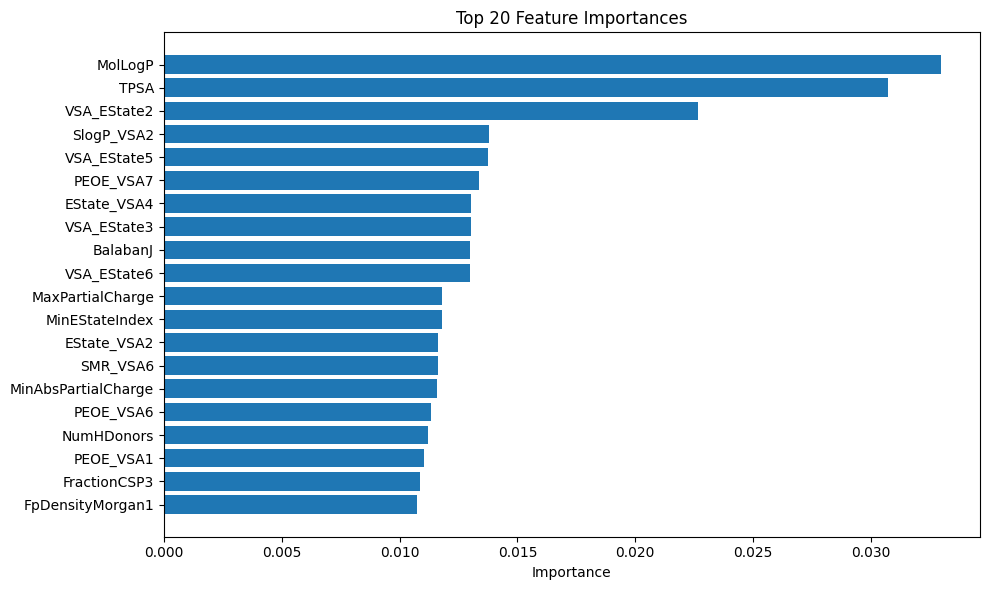

In [122]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]  # tri décroissant

feature_names = X_train.columns


import matplotlib.pyplot as plt

top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances[indices[:top_n]][::-1], align='center')
plt.yticks(range(top_n), feature_names[indices[:top_n]][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


In [123]:
from joblib import dump
# dump(best_model, 'models/rf_model_2.joblib')

In [124]:
print(smiles_list[:10])

['Brc1cc(Br)c(Oc2cc(Br)c(Br)cc2Br)cc1Br', 'Brc1ccc2[nH]c3c(c2c1)CCCC3Nc1ccccc1', 'Brc1ccc2c(NC3=NCC4(CN5CCC4CC5)O3)ncnn12', 'Brc1cnc2nc(N3CCN4CCC3CC4)oc2c1', 'Brc1cncc(COCC2(c3ccccc3)CCNCC2)c1', 'C#CCCCCCCCCCNC(=O)Oc1cccc(-n2ccc(C(N)=O)c2)c1', 'C#CCN(CC#C)C(=O)C1(c2cccs2)CC1CN', 'C#CCNc1ccnc2sc3c(=O)n(-c4ccc(OC)cc4)cnc3c12', 'C#Cc1ccc(COC(=O)N2CCC(CNc3ncccn3)CC2)cc1', 'C#Cc1cccc(Nc2ncnc3cc(OC)c(OCCCCCCC(=O)NO)cc23)c1']


# TESTSTSTSTS 2

In [138]:
from joblib import load

test_df = pd.read_csv('data/test_2.csv')
X_test_2 = test_df.iloc[:, 2:201]

# print(X_test_2.head())

# model = load('models/rf_model_2.joblib')
model = best_model
y_pred_2 = model.predict(X_test_2.values)

final_df = pd.DataFrame({
    'smiles': test_df['smiles'],
    'class': y_pred_2
})

# final_df.to_csv('data/pred_2_noa.csv', index=False)

c:\Users\nonoa\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [143]:
y_pred_3 = pd.read_csv('data/pred_2.csv')['class'].values

In [145]:
print(np.mean(y_pred_2 == 0), np.mean(y_pred_2 == 1))
print(np.mean(y_pred_3 == 0), np.mean(y_pred_3 == 1))

0.7677824267782427 0.23221757322175732
0.7635983263598326 0.23640167364016737


In [140]:
def compare_csv_files(file1, file2):
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    # Vérifier les colonnes
    if set(df1.columns) != set(df2.columns):
        print("Les fichiers CSV n'ont pas les mêmes colonnes.")
        return

    # Comparer les valeurs
    differences = df1.compare(df2)

    if differences.empty:
        print("Les fichiers CSV sont identiques.")
    else:
        print("Différences trouvées :")
        print(differences)
        print(f"Nombre de différences : {len(differences)}")

    y_1 = df1['class'].values
    y_2 = df2['class'].values
    print(np.sum(y_1 == 0), np.sum(y_1 == 1))
    print(np.sum(y_2 == 0), np.sum(y_2 == 1))

In [141]:
compare_csv_files('data/pred_2_noa.csv', 'data/pred_2.csv')

Différences trouvées :
    class      
     self other
2     0.0   1.0
13    0.0   1.0
18    0.0   1.0
19    0.0   1.0
50    1.0   0.0
97    1.0   0.0
124   0.0   1.0
136   1.0   0.0
137   1.0   0.0
138   1.0   0.0
139   1.0   0.0
188   1.0   0.0
210   1.0   0.0
213   1.0   0.0
216   1.0   0.0
249   0.0   1.0
255   1.0   0.0
270   1.0   0.0
271   1.0   0.0
272   0.0   1.0
278   0.0   1.0
300   0.0   1.0
317   1.0   0.0
320   0.0   1.0
326   0.0   1.0
327   1.0   0.0
332   1.0   0.0
333   1.0   0.0
335   0.0   1.0
353   0.0   1.0
374   0.0   1.0
375   0.0   1.0
377   0.0   1.0
379   0.0   1.0
454   0.0   1.0
473   0.0   1.0
Nombre de différences : 36
367 111
365 113


#### Visualisation des séries et comparaison avec ma fonction de clusterisation

In [130]:
test_df = pd.read_csv('data/test_2.csv')

ecfc_test = test_df.iloc[:, 200:2248].values
fcfc_test = test_df.iloc[:, 2248:-1].values
smiles_test_list = test_df['smiles'].tolist()

descriptors_test = test_df.iloc[:, :200]


In [131]:

#Convertir les empreintes en vecteurs de bits
ecfc_bitvect_test = [numpy_to_bitvect(fp) for fp in tqdm(ecfc_test)]
fcfc_bitvect_test = [numpy_to_bitvect(fp) for fp in tqdm(fcfc_test)]
# Calculer la matrice de Tanimoto
tanimoto_matrix_ecfc_test = calculate_tanimoto_matrix(ecfc_bitvect_test)
tanimoto_matrix_fcfc_test = calculate_tanimoto_matrix(fcfc_bitvect_test)

100%|██████████| 478/478 [00:00<00:00, 2063.17it/s]


In [132]:
dist_matrix_test = calculate_distance_matrix(tanimoto_matrix_ecfc_test, tanimoto_matrix_fcfc_test) # i am the chosen one


In [133]:
clusters_test = cluster_hierarchical(dist_matrix_test, target_cluster_size=80)


In [134]:
import re
series = [int(re.search(r'series_(\d+)', s).group(1)) for s in test_df['series'].tolist()]

print(np.unique(series))
print("Taille des séries chimiques dans le test set:")
tailles=[]
for s in np.unique(series):
    taille = np.sum(np.array(series) == s)
    print(f"Série {s}: {taille} molécules")
    tailles.append(taille)
print(np.mean(tailles), np.std(tailles))

[1 2 3 4 5 6]
Taille des séries chimiques dans le test set:
Série 1: 116 molécules
Série 2: 67 molécules
Série 3: 42 molécules
Série 4: 38 molécules
Série 5: 102 molécules
Série 6: 113 molécules
79.66666666666667 32.262809686834295


In [135]:
from sklearn.metrics import adjusted_rand_score

# Extraire les entiers des chaînes de caractères des séries
series = [int(s.split('_')[1]) for s in test_df['series'].tolist()]
# Comparer les clusters avec les séries
ari = adjusted_rand_score(series, clusters_test)
print(f"Adjusted Rand Index: {ari:.4f}")

Adjusted Rand Index: 0.8762


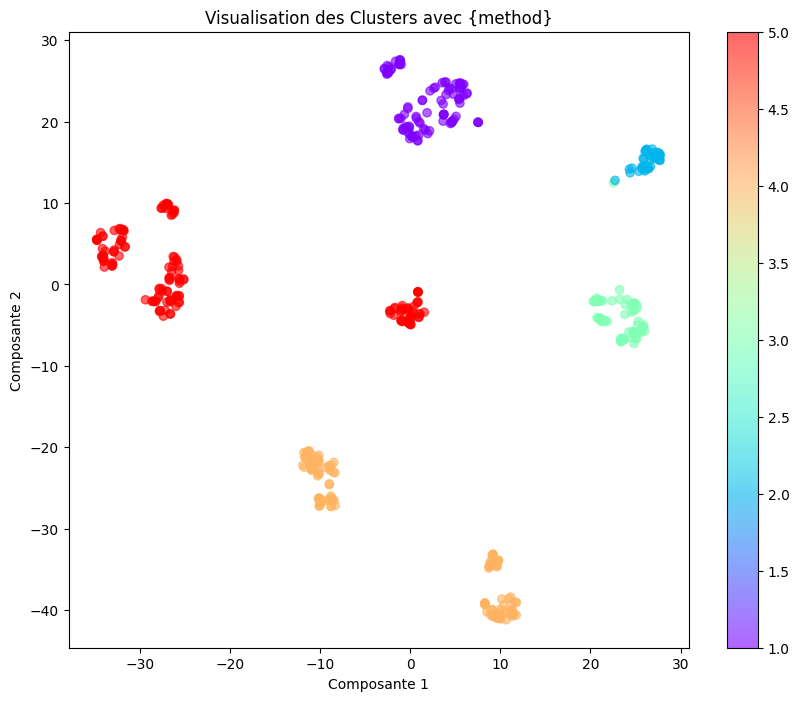

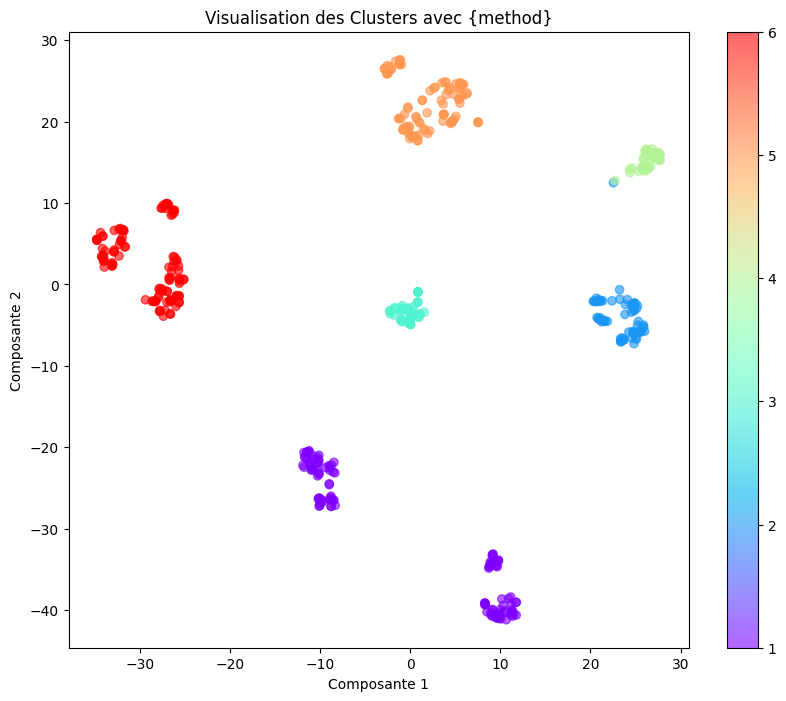

In [136]:
visualize_clusters(dist_matrix_test, clusters_test, 't-sne')
visualize_clusters(dist_matrix_test, series, 't-sne')